In [1]:
from linares_plot import *
from missdirection_model import *
%load_ext autoreload
%autoreload



### Control / Standard

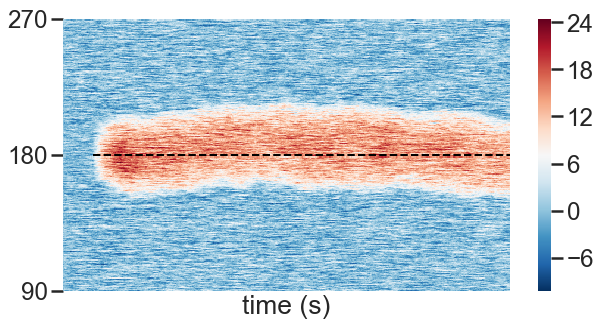

In [189]:
control = model(totalTime=1500, targ_onset_1=100, targ_onset_2=3000, presentation_period=100, angle_target_i=180, 
            angle_separation=70, tauE=20, tauI=10,  n_stims=2, I0E=0.1, I0I=0.5, 
           GEE=0.068,
           GII= 0.13,
           GEI=0.13,
           GIE=0.042, 
           sigE=9.5, sigI=5., 
           kappa_E=45, 
           kappa_I=0.5, #OFF
           kappa_stim=40., N=512, stim_strengthE=9.20, stim_strengthI=0.,
           plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False)



### Direction

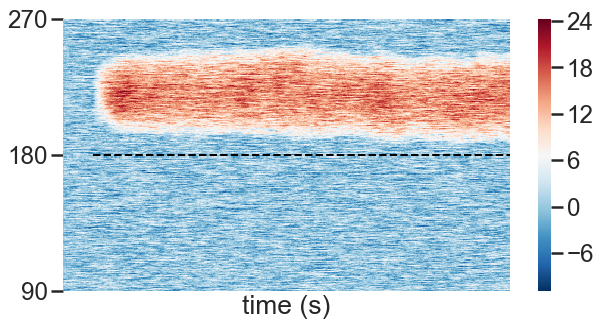

36.66

In [156]:
direction = model(totalTime=1500, targ_onset_1=100, targ_onset_2=3000, presentation_period=100, angle_target_i=220, 
            angle_separation=70, tauE=20, tauI=10,  n_stims=2, I0E=0.1, I0I=0.5, 
           GEE=0.068,
           GII= 0.13,
           GEI=0.13,
           GIE=0.042, 
           sigE=9.5, sigI=5., 
           kappa_E=45, 
           kappa_I=0.5, #OFF
           kappa_stim=40., N=512, stim_strengthE=9.20, stim_strengthI=0.,
           plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False)



### Diminishment

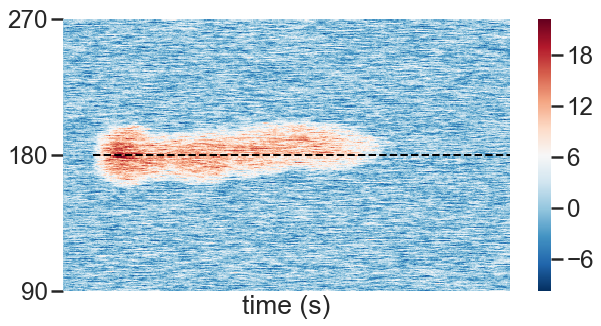

18.52

In [11]:
diminishment = model(totalTime=1500, targ_onset_1=100, targ_onset_2=3000, presentation_period=100, angle_target_i=180, 
            angle_separation=70, tauE=20, tauI=10,  n_stims=2, I0E=-4.65, I0I=0.5, 
           GEE=0.068,
           GII= 0.13,
           GEI=0.13,
           GIE=0.042, 
           sigE=9.5, sigI=5., 
           kappa_E=45, 
           kappa_I=0.5, #OFF
           kappa_stim=40., N=512, stim_strengthE=9.20, stim_strengthI=0.,
           plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False)



### Division

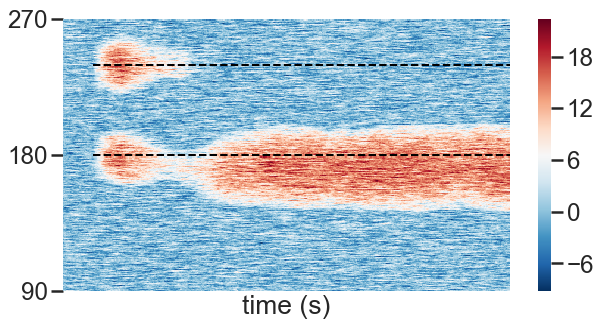

10.95

In [9]:
division = model(totalTime=1500, targ_onset_1=100, targ_onset_2=100, presentation_period=100, angle_target_i=180, 
            angle_separation=60, tauE=20, tauI=10,  n_stims=2, I0E=0.1, I0I=0.5, 
           GEE=0.068,
           GII= 0.13,
           GEI=0.13,
           GIE=0.042, 
           sigE=9.5, sigI=5., 
           kappa_E=45, 
           kappa_I=0.5, #OFF
           kappa_stim=40., N=512, stim_strengthE=9.20, stim_strengthI=0.,
           plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False)



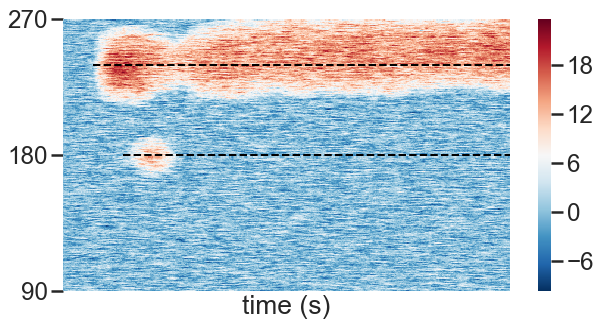

66.78

In [10]:
division_a_m_prio = model(totalTime=1500, targ_onset_1=200, targ_onset_2=100, presentation_period=100, angle_target_i=180, 
            angle_separation=60, tauE=20, tauI=10,  n_stims=2, I0E=0.1, I0I=0.5, 
           GEE=0.068,
           GII= 0.13,
           GEI=0.13,
           GIE=0.042, 
           sigE=9.5, sigI=5., 
           kappa_E=45, 
           kappa_I=0.5, #OFF
           kappa_stim=40., N=512, stim_strengthE=9.20, stim_strengthI=0.,
           plot_connectivity=False, plot_rate=False, plot_hm=True , plot_fit=False)



### Simulations of control

In [ ]:
n_simulations =200
numcores = multiprocessing.cpu_count() -1

s_standard = Parallel(n_jobs = numcores)(delayed(model)(totalTime=1500, targ_onset_1=100, targ_onset_2=3000, presentation_period=100, angle_target_i=180, 
            angle_separation=70, tauE=20, tauI=10,  n_stims=2, I0E=0.1, I0I=0.5, 
           GEE=0.068,
           GII= 0.13,
           GEI=0.13,
           GIE=0.042, 
           sigE=9.5, sigI=5., 
           kappa_E=45, 
           kappa_I=0.5, #OFF
           kappa_stim=40., N=512, stim_strengthE=9.20, stim_strengthI=0.,
           plot_connectivity=False, plot_rate=False, plot_hm=False , plot_fit=False) for i in range(0,n_simulations)) 


bias_stand = [s_standard[i][0] for i in range(len(s_standard))]
active_stand = [s_standard[i][2] for i in range(len(s_standard))]

print( 'Mean abs bias: ' +str(np.round(np.mean(bias_stand),2)) + ', detected: ' +str(np.sum(active_stand)*100/n_simulations ) + '%' )


### Simulations of direction: distances

In [78]:
# a_ts = list(np.arange(0, 180, 10))*200
# s_direction = Parallel(n_jobs = numcores)(delayed(model)(totalTime=1500, targ_onset_1=100, targ_onset_2=3000, presentation_period=100, angle_target_i=atn, 
#             angle_separation=70, tauE=20, tauI=10,  n_stims=2, I0E=0.1, I0I=0.5, 
#            GEE=0.068,
#            GII= 0.13,
#            GEI=0.13,
#            GIE=0.042, 
#            sigE=9.5, sigI=5., 
#            kappa_E=45, 
#            kappa_I=0.5, #OFF
#            kappa_stim=40., N=512, stim_strengthE=9.20, stim_strengthI=0.,
#            plot_connectivity=False, plot_rate=False, plot_hm=False , plot_fit=False) for atn in a_ts) 


# bias_direction = [s_direction[i][0] for i in range(len(s_direction))]
# active_direction = [s_direction[i][2] for i in range(len(s_direction))]


In [79]:
# df_dist=pd.DataFrame(active_direction)
# df_dist['distance'] = 180 - np.array(list(np.arange(0, 180, 10))*200)
# df_dist.columns=['detection', 'distance']
##df_dist.to_excel('distance_dependence_direction.xlsx')

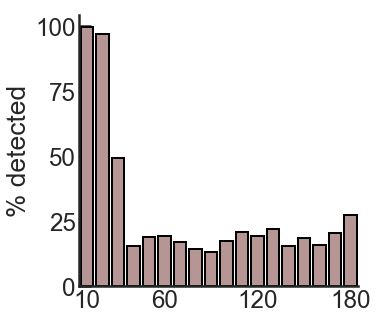

In [178]:
### Bars
df_dist=pd.read_excel('distance_dependence_direction.xlsx')

f = plt.figure(figsize=(5,5))
ax = f.add_subplot(111)
g = sns.barplot(x="distance", y="detection", data=df_dist, estimator=np.mean,
                ci=None,  color='rosybrown',  edgecolor='black', ecolor='k')

ax.set_yticks([0, 0.25, 0.50, 0.75, 1])
ax.set_yticklabels([0,  25, 50, 75, 100])
ax.set_xticks([0,5,11, 17])
ax.set_xticklabels([10, 60, 120,180 ])
ax.set_xlabel('')
ax.set_ylabel('% detected')
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)
ax.tick_params(direction='in') #direction

### Simulations of diminishment: background input


In [100]:
# ioe_ls = list(np.linspace(-4, -5, 11))*200

# diminish_intens = Parallel(n_jobs = numcores)(delayed(model)(totalTime=1500, targ_onset_1=100, targ_onset_2=3000, presentation_period=100, angle_target_i=180, 
#             angle_separation=70, tauE=20, tauI=10,  n_stims=2, I0E=ioes, I0I=0.5, 
#            GEE=0.068,
#            GII= 0.13,
#            GEI=0.13,
#            GIE=0.042, 
#            sigE=9.5, sigI=5., 
#            kappa_E=45, 
#            kappa_I=0.5, #OFF
#            kappa_stim=40., N=512, stim_strengthE=9.20, stim_strengthI=0.,
#            plot_connectivity=False, plot_rate=False, plot_hm=False , plot_fit=False) for ioes in ioe_ls) 


# bias_diminish_int = [diminish_intens[i][0] for i in range(len(diminish_intens))]
# active_diminish_int = [diminish_intens[i][2] for i in range(len(diminish_intens))]

In [101]:
# df_ioe=pd.DataFrame(active_diminish_int)
# df_ioe['I0E'] = ioe_ls
# df_ioe.columns=['detection', 'I0E']
## df_ioe.to_excel('IOE_diminish.xlsx')

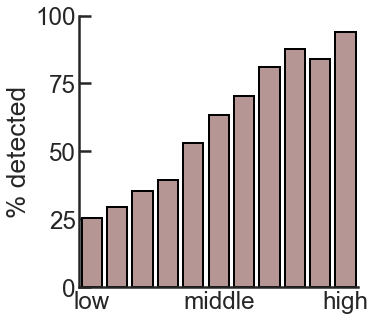

In [179]:
df_ioe = pd.read_excel('IOE_diminish.xlsx')


f = plt.figure(figsize=(5,5))
ax = f.add_subplot(111)
g = sns.barplot(x="I0E", y="detection", data=df_ioe, estimator=np.mean,
                ci=None,  color='rosybrown',  edgecolor='black', ecolor='k')

ax.set_yticks([0, 0.25, 0.50, 0.75, 1])
ax.set_yticklabels([0,  25, 50, 75, 100])
ax.set_xticks([0,5,10])
ax.set_xticklabels(['low', 'middle', 'high' ])
ax.set_xlabel('')
ax.set_ylabel('% detected')
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)
ax.tick_params(direction='in') #direction

### Simulations of division: normal

In [ ]:
n_simulations =200
numcores = multiprocessing.cpu_count() -1 

s_division = Parallel(n_jobs = numcores)(delayed(model)(totalTime=1500, targ_onset_1=100, targ_onset_2=100, presentation_period=100, angle_target_i=180, 
            angle_separation=60, tauE=20, tauI=10,  n_stims=2, I0E=0.1, I0I=0.5, 
           GEE=0.068,
           GII= 0.13,
           GEI=0.13,
           GIE=0.042, 
           sigE=9.5, sigI=5., 
           kappa_E=45, 
           kappa_I=0.5, #OFF
           kappa_stim=40., N=512, stim_strengthE=9.20, stim_strengthI=0.,
           plot_connectivity=False, plot_rate=False, plot_hm=False , plot_fit=False) for i in range(0,n_simulations)) 


bias_division = [s_division[i][0] for i in range(len(s_division))]
active_division = [s_division[i][2] for i in range(len(s_division))]
number_bumps = [s_division[i][7] for i in range(len(s_division))]

print( 'Mean abs bias: ' +str(np.round(np.mean(bias_division),2)) + ', detected: ' +str(np.sum(active_division)*100/n_simulations ) + '%' )

### Simulations of division: priority movement

In [ ]:
n_simulations =200
numcores = multiprocessing.cpu_count() -1

s_division_a_m_prio = Parallel(n_jobs = numcores)(delayed(model)(totalTime=1500, targ_onset_1=200, targ_onset_2=100, presentation_period=100, angle_target_i=180, 
            angle_separation=60, tauE=20, tauI=10,  n_stims=2, I0E=0.1, I0I=0.5, 
           GEE=0.068,
           GII= 0.13,
           GEI=0.13,
           GIE=0.042, 
           sigE=9.5, sigI=5., 
           kappa_E=45, 
           kappa_I=0.5, #OFF
           kappa_stim=40., N=512, stim_strengthE=9.20, stim_strengthI=0.,
           plot_connectivity=False, plot_rate=False, plot_hm=False , plot_fit=False) for i in range(0,n_simulations)) 


bias_division_a_m_prio = [s_division_a_m_prio[i][0] for i in range(len(s_division_a_m_prio))]
active_division_a_m_prio = [s_division_a_m_prio[i][2] for i in range(len(s_division_a_m_prio))]
number_bumps = [s_division_a_m_prio[i][7] for i in range(len(s_division_a_m_prio))]

print( 'Mean abs bias: ' +str(np.round(np.mean(bias_division_a_m_prio),2)) + ', detected: ' +str(np.sum(active_division_a_m_prio)*100/n_simulations ) + '%' )


In [ ]:
Standard = pd.DataFrame(active_stand)
Standard['type']='standard'
Standard.columns=['detection', 'type']

Division = pd.DataFrame(active_division)
Division['type']='division'
Division.columns=['detection', 'type']

Division_mp = pd.DataFrame(active_division_a_m_prio)
Division_mp['type']='division_mp'
Division_mp.columns=['detection', 'type']

df_div = pd.concat([Standard, Division, Division_mp ])
# df_div.to_excel('detection_division_cond.xlsx')

In [ ]:
### Bars
#df_div=pd.read_excel('detection_division_cond.xlsx')

f = plt.figure(figsize=(5,5))
ax = f.add_subplot(111)
g = sns.barplot(x="type", y="detection", data=df_div, estimator=np.mean,
                order=['standard','division', 'division_mp' ], 
            ci=None,  color='rosybrown',  edgecolor='black', ax=ax, ecolor='k')

ax.set_yticks([0, 0.25, 0.50, 0.75, 1])
ax.set_yticklabels([0,  25, 50, 75, 100])
ax.set_xlabel('')
ax.set_ylabel('% detected')
ax.set_xticklabels(['ctrl', 'div.', 'div mp.'])
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)
ax.tick_params(direction='in') #direction

adjust_spines(g, ['left', 'bottom'])

In [191]:
df_div.loc[df_div['type']=='standard']

,detection,type
0,True,standard
1,True,standard
2,True,standard
3,True,standard
4,True,standard
5,True,standard
6,True,standard
7,True,standard
8,True,standard
9,True,standard


## Figure

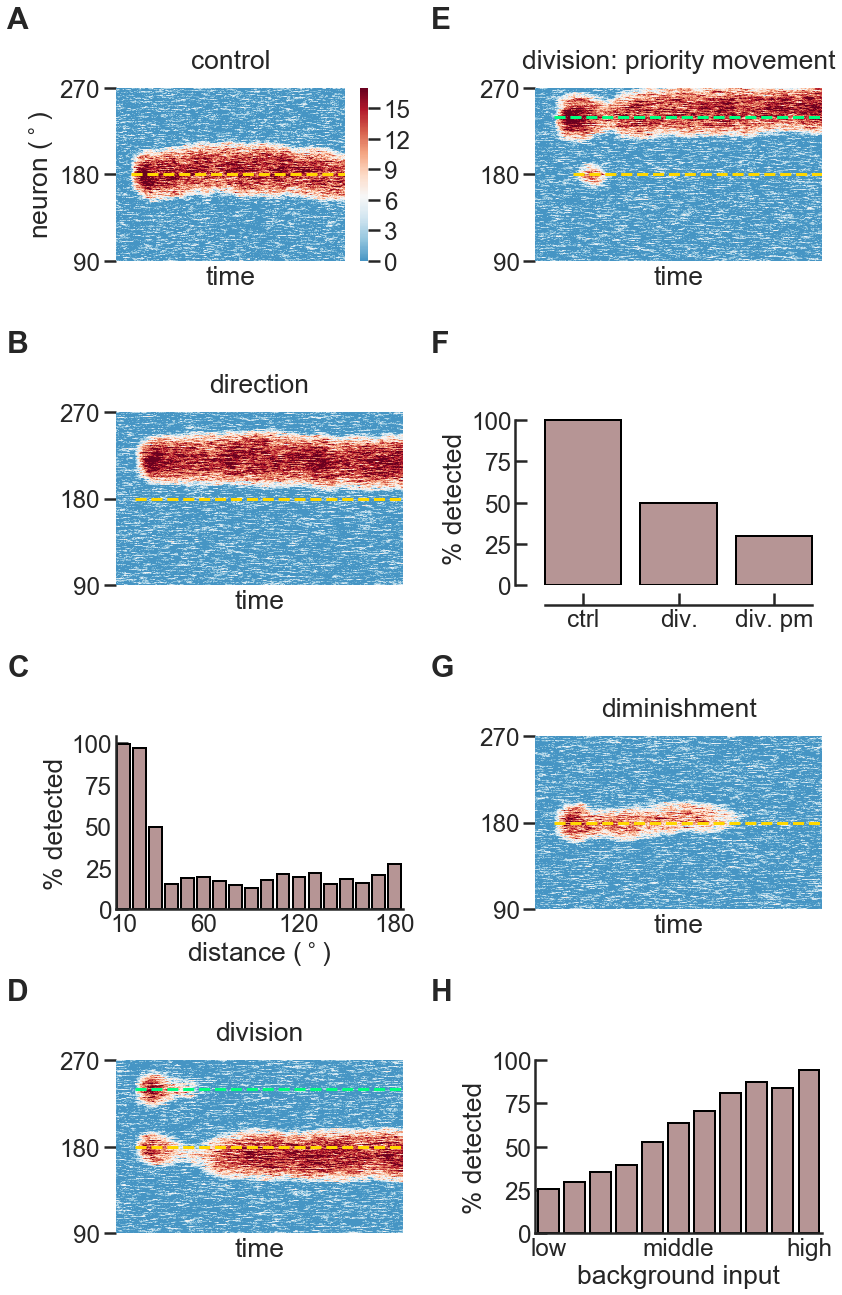

In [190]:
f = plt.figure(figsize=(12,18))
ax1 = f.add_subplot(421)
ax2 = f.add_subplot(423)
ax3 = f.add_subplot(425)
ax4 = f.add_subplot(427)
ax5 = f.add_subplot(422)
ax6 = f.add_subplot(424)
ax7 = f.add_subplot(426)
ax8 = f.add_subplot(428)

p_targ2 = int((N * np.degrees(np.radians(180)))/360)
p_targ1 = int((N * np.degrees(np.radians(180+60)))/360)

pal_cyan = sns.color_palette("RdBu_r", n_colors=200)[40:] #RdBu_r
ltc= 'gold'  #'springgreen'
lw_t=3



f.text(0.01, 1.0, "A", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.50, 1,  "E", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)

f.text(0.01, 0.75, "B", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.50, 0.75,  "F", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)

f.text(0.01, 0.5, "C", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.50, 0.5,  "G", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)

f.text(0.01, 0.25, "D", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)
f.text(0.50, 0.25,  "H", weight="bold", horizontalalignment='left', verticalalignment='center', fontsize=30)



#### Standard
RE_sorted=flipud(control[5])
sns.set_context("poster", font_scale=1.1)
sns.set_style("ticks")
sns.heatmap(RE_sorted, cmap=pal_cyan, vmin=0, vmax=17, ax=ax1, cbar=True)
stimon = 50
stimoff = 50 + floor(250/2) ;
nsteps=int(floor(750));
N=512
p_targ2 = int((N * np.degrees(np.pi ))/360)
ax1.set_title('control', pad=20) # remove title
ax1.set_ylabel(r'neuron ($^\circ$)')
ax1.set_xlabel('time')
ax1.plot([stimon, nsteps], [p_targ2, p_targ2], ls='--', color =ltc, linewidth=lw_t) ## flipped, so it is p_target 
ax1.set_yticks([N/4, N/2,  3*N/4 ])
ax1.set_yticklabels(['90','180', '270'])
ax1.set_ylim( N/4, 3*N/4)
ax1.set_xticks([])
# ax1.plot([stimon, stimon,], [0+20, N-20], 'k-', linewidth=0.5)
# ax1.plot([stimoff, stimoff,], [0+20, N-20], 'k-', linewidth=0.5)



#### Direction
RE_sorted=flipud(direction[5])
sns.heatmap(RE_sorted, cmap=pal_cyan, vmin=0, vmax=17, ax=ax2, cbar=False)
stimon = 50
stimoff = 50 + floor(250/2) ;
nsteps=int(floor(750));
N=512
p_targ2 = int((N * np.degrees(np.pi ))/360)
ax2.set_title('direction', pad=20) # remove title

ax2.set_xlabel('time')
ax2.plot([stimon, nsteps], [p_targ2, p_targ2], ls='--', color =ltc, linewidth=lw_t) ## flipped, so it is p_target 
ax2.set_xticks([])
#ax2.set_ylabel(r'neuron ($^\circ$)')
ax2.set_yticks([N/4, N/2,  3*N/4 ])
ax2.set_yticklabels(['90','180', '270'])
ax2.set_ylim( N/4, 3*N/4)
# ax2.plot([stimon, stimon,], [0+20, N-20], 'k-', linewidth=0.5)
# ax2.plot([stimoff, stimoff,], [0+20, N-20], 'k-', linewidth=0.5)


#### direction distance

g = sns.barplot(x="distance", y="detection", data=df_dist, estimator=np.mean,
                ci=None,  color='rosybrown', ax=ax3,  edgecolor='black', ecolor='k')

#g.set_ylim(0, 0.15)
ax3.set_yticks([0, 0.25, 0.50, 0.75, 1])
ax3.set_yticklabels([0,  25, 50, 75, 100])
ax3.set_xticks([0,5,11, 17])
ax3.set_xticklabels([10, 60, 120,180 ])
#ax3.set_xlabel('distance')
ax3.set_ylabel('% detected')
ax3.set_xlabel(r'distance ($^\circ$)');
#ax6.set_xticklabels(['std', 'dir.', 'dim.', 'div.', 'div mp.'])
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)
ax3.tick_params(direction='in') #direction




#### Division
RE_sorted=flipud(division[5])
sns.set_context("poster", font_scale=1.1)
sns.set_style("ticks")
sns.heatmap(RE_sorted, cmap=pal_cyan, vmin=0, vmax=17, ax=ax4, cbar=False)
stimon = 50
stimoff = 50 + floor(250/2) ;
nsteps=int(floor(750));
N=512
p_targ2 = int((N * np.degrees(np.pi ))/360)
ax4.set_title('division', pad=20) # remove title
ax4.set_ylabel('')
ax4.set_xlabel('')
#ax4.set_ylabel(r'neuron ($^\circ$)')
ax4.plot([50, nsteps], [p_targ2, p_targ2], ls='--', color =ltc, linewidth=lw_t) ## flipped, so it is p_target 
ax4.plot([50, nsteps], [p_targ1, p_targ1], ls='--', color ='springgreen', linewidth=lw_t) #

ax4.set_xticks([])
ax4.set_yticks([N/4, N/2,  3*N/4 ])
ax4.set_yticklabels(['90','180', '270'])
ax4.set_ylim( N/4, 3*N/4)
ax4.set_xlabel('time')
#ax6.set_yticklabels([])
# ax4.plot([stimon, stimon,], [0+20, N-20], 'b-', linewidth=2)
# ax4.plot([stimoff, stimoff,], [0+20, N-20], 'b-', linewidth=2)


plt.tight_layout(h_pad=1, w_pad=1.5)



#### Division PM
RE_sorted=flipud(division_a_m_prio[5])
sns.set_context("poster", font_scale=1.1)
sns.set_style("ticks")
sns.heatmap(RE_sorted, cmap=pal_cyan, vmin=0, vmax=17, ax=ax5, cbar=False)
stimon = 50
stimoff = 50 + floor(250/2) ;
nsteps=int(floor(750));
N=512
p_targ2 = int((N * np.degrees(np.pi ))/360)
ax5.set_title('division: priority movement', pad=20) # remove title
ax5.set_ylabel('')
ax5.set_xlabel('time')
#ax5.set_ylabel(r'neuron ($^\circ$)')
ax5.plot([100, nsteps], [p_targ2, p_targ2], ls='--', color =ltc, linewidth=lw_t) ## flipped, so it is p_target 
ax5.plot([50, nsteps], [p_targ1, p_targ1], ls='--', color ='springgreen', linewidth=lw_t) #

ax5.set_xticks([])
ax5.set_yticks([N/4, N/2,  3*N/4 ])
ax5.set_yticklabels(['90','180', '270'])
ax5.set_ylim( N/4, 3*N/4)
#ax5.set_xlabel('time')
# ax5.plot([stimon, stimon,], [0+20, N-20], 'b-', linewidth=2)
# ax5.plot([stimoff, stimoff,], [0+20, N-20], 'b-', linewidth=2)


plt.tight_layout(h_pad=1, w_pad=1.5)



#### Division graph comparision

g = sns.barplot(x="type", y="detection", data=df_div, estimator=np.mean,
                order=['standard','division', 'division_mp' ], 
            ci=None,  color='rosybrown',  edgecolor='black', ax=ax6, ecolor='k')

#g.set_ylim(0, 0.15)
ax6.set_yticks([0, 0.25, 0.50, 0.75, 1])
ax6.set_yticklabels([0,  25, 50, 75, 100])
ax6.set_xlabel('')
ax6.set_ylabel('% detected')
ax6.set_xticklabels(['ctrl', 'div.', 'div. pm'])
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)
ax6.tick_params(direction='in') #direction

adjust_spines(g, ['left', 'bottom'])





#### Diminishment
RE_sorted=flipud(diminishment[5])
sns.set_context("poster", font_scale=1.1)
sns.set_style("ticks")
sns.heatmap(RE_sorted, cmap=pal_cyan, vmin=0, vmax=17, ax=ax7, cbar=False)
stimon = 50
stimoff = 50 + floor(250/2) ;
nsteps=int(floor(750));
N=512
p_targ2 = int((N * np.degrees(np.pi ))/360)
ax7.set_title('diminishment', pad=20) # remove title
ax7.set_ylabel('')
ax7.set_xlabel('')
#ax7.set_ylabel(r'neuron ($^\circ$)')
ax7.plot([stimon, nsteps], [p_targ2, p_targ2], ls='--', color =ltc, linewidth=lw_t) ## flipped, so it is p_target 
ax7.set_xticks([])
ax7.set_yticks([N/4, N/2,  3*N/4 ])
ax7.set_yticklabels(['90','180', '270'])
ax7.set_ylim( N/4, 3*N/4)
ax7.set_xlabel('time')




#### Diminish with I0E

g = sns.barplot(x="I0E", y="detection", data=df_ioe, estimator=np.mean,
                ci=None,  color='rosybrown', ax=ax8, edgecolor='black', ecolor='k')

ax8.set_yticks([0, 0.25, 0.50, 0.75, 1])
ax8.set_yticklabels([0,  25, 50, 75, 100])
ax8.set_xticks([0,5,10])
ax8.set_xticklabels(['low', 'middle', 'high' ])
ax8.set_xlabel('background input')
ax8.set_ylabel('% detected')
#ax6.set_xticklabels(['std', 'dir.', 'dim.', 'div.', 'div mp.'])
g.spines['right'].set_visible(False)
g.spines['top'].set_visible(False)
ax8.tick_params(direction='in') #direction

plt.tight_layout(h_pad=2)

